## Imports

In [86]:
import os
import re
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from datetime import datetime, timezone
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

nltk.download("rslp")

[nltk_data] Downloading package rslp to /home/gus/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

### Importando as stopwords do NLTK

In [87]:
stopwords = nltk.corpus.stopwords.words('portuguese')

### Configurando o tamanho padrão das figuras

In [88]:
plt.rcParams["figure.figsize"] = (16, 8)

## Funções utilizadas durante a análise

In [89]:
def stemming(texto: str) -> str:
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    palavras = [stemmer.stem(palavra) for palavra in texto.split()]
    return " ".join(palavras)


def remover_stop_words(texto: str, stop_words: list) -> str:
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(stop_words)
    texto = " ".join(list(filter(lambda x: x not in stopwords, texto.split())))
    return texto


def formatar_texto(texto: str) -> str:
    texto = (
        re.sub(r"(http\S+)|(@\w+)", "", texto)  # remove links, usuários #
        .replace(".", "")
        .replace(";", "")
        .replace("—", "")
    )

    texto = re.sub(r"(  +)", " ", texto)  # remove espaços duplos
    texto = texto.lower().strip()

    return texto


def get_top_ngram(corpus, gram_size=None, top_gram=10):
    vec = CountVectorizer(ngram_range=(gram_size, gram_size)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_gram]

def datetime_to_period(hour):
    if hour >= 0 and hour < 6:
        return "overnight"
    elif hour >= 6 and hour < 12:
        return "morning"
    elif hour >= 12 and hour < 18:
        return "afternoon"
    elif hour >= 18 and hour < 24:
        return "night"

<h2 style=""> Carregando dataset.</h2>

In [90]:
df_positivo = pd.read_csv("../data/processed/tweets-positivos.csv", delimiter="\t")
df_negativo = pd.read_csv("../data/processed/tweets-negativos.csv", delimiter="\t")

In [91]:
df_positivo.head()

,user_name,tweet,date,label,day_period
0,ttdavit0ri4,se a pila me pagar eu vou no outback amanhã,2022-06-10 02:25:24+00:00,positivo,overnight
1,vtcamuzzi,queria ir no outback comer o fondue no dia dos...,2022-06-08 15:31:11+00:00,positivo,afternoon
2,juxtonie,e eu que fui tirar uma foto do novo fondue do ...,2022-06-01 00:31:40+00:00,positivo,overnight
3,gabigduda,quem vai pagar um chopp no happy hour do outba...,2022-05-13 18:29:12+00:00,positivo,night
4,lahhhaffz,"tô entre “comemorar” no outback, coco bambu ou...",2022-05-02 22:16:49+00:00,positivo,night


<h2 style=""> unificando os dataframes p/ não ter que repetir código.
Após as analises, os dados serão salvos em bases distintas.</h2>

In [92]:
df = pd.concat([df_positivo, df_negativo], ignore_index=True, axis=0)
del df_positivo, df_negativo

<h2 style=""> Gerando novos dados utilizando o dataframe.</h2>

In [93]:
df = df.assign(
    number_words = df.tweet.apply(lambda x: len(x.split(" "))),
)  # adiciona coluna com número de palavras

df = df.assign(
    avg_word_length=df.tweet.str.split()
    .apply(lambda x: [len(i) for i in x])
    .map(lambda x: np.mean(x))
)  # adiciona coluna com média de caracteres por palavra no tweet

formated_df = df.drop(
    df[df.number_words < 5].index
)  # remove tweets com menos de 5 palavras

formated_df

,user_name,tweet,date,label,day_period,number_words,avg_word_length
0,ttdavit0ri4,se a pila me pagar eu vou no outback amanhã,2022-06-10 02:25:24+00:00,positivo,overnight,10,3.400000
1,vtcamuzzi,queria ir no outback comer o fondue no dia dos...,2022-06-08 15:31:11+00:00,positivo,afternoon,17,4.470588
2,juxtonie,e eu que fui tirar uma foto do novo fondue do ...,2022-06-01 00:31:40+00:00,positivo,overnight,21,3.619048
3,gabigduda,quem vai pagar um chopp no happy hour do outba...,2022-05-13 18:29:12+00:00,positivo,night,13,3.846154
4,lahhhaffz,"tô entre “comemorar” no outback, coco bambu ou...",2022-05-02 22:16:49+00:00,positivo,night,9,5.000000
...,...,...,...,...,...,...,...
59195,hellojof,como assim nao tem mais a corn &amp bacon?? pi...,2014-08-18 16:22:14+00:00,negativo,afternoon,16,4.000000
59196,abelstargirrl,a fome é tanta que eu comeria uma pizza de 12 ...,2014-02-04 01:13:29+00:00,negativo,overnight,16,3.625000
59197,larissanader_,pq q a pizza hut aqui do lado fechou? hj seria...,2013-12-11 20:29:25+00:00,negativo,night,14,3.285714
59198,mandamarques_,pizza hut ta quase ganhando da distrivideocade...,2012-09-02 23:23:35+00:00,negativo,night,9,5.555556


## Informações sombre o dataframe.

In [94]:
print(df.shape)
print(formated_df.describe())

formated_df.sample(5)

(59200, 7)
       number_words  avg_word_length
count  53426.000000     53426.000000
mean      12.894452         4.426481
std        8.404972         0.896907
min        5.000000         1.000000
25%        7.000000         3.857143
50%       10.000000         4.285714
75%       15.000000         4.800000
max       61.000000        16.200000


,user_name,tweet,date,label,day_period,number_words,avg_word_length
19027,JooPedroSampai7,hoje ta a cara da custela do outback com basta...,2018-06-09 17:36:21+00:00,positivo,afternoon,11,4.090909
2459,KelemRa,vou ali no outback porque quero o parabéns de lá,2019-07-30 22:08:23+00:00,positivo,night,10,3.900000
7954,Akayran,jantarzinho com ela outback shopping taboão,2017-05-21 00:30:45+00:00,positivo,overnight,6,6.333333
52684,renjuwus,aqui mal tem starbucks quem dirá o resto kakak...,2022-01-13 01:31:00+00:00,negativo,overnight,11,4.636364
24229,estellafairenf,manooooooo tem um menino do meu lado aqui no ô...,2019-04-12 17:52:37+00:00,positivo,afternoon,45,3.933333


## Histograma da quantidade de palavras nos tweets.
#### Nota-se claramente uma tendência dos tweets serem textos curtos, majoritariamente com menos de 20 palavras.

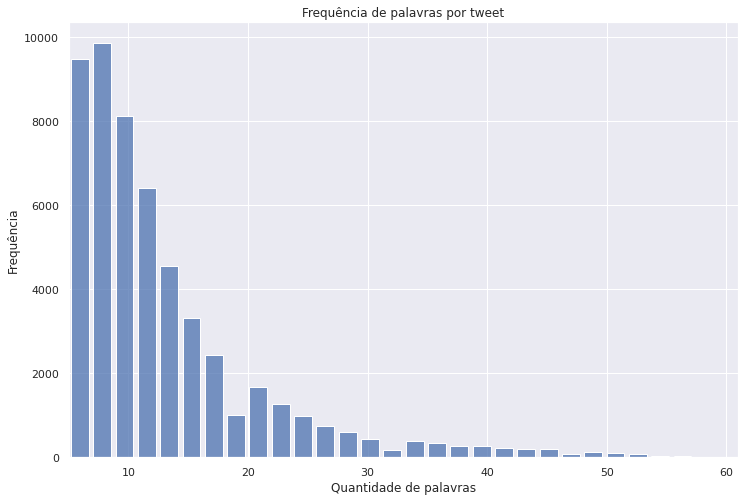

In [62]:
sns.set(rc={"figure.figsize": (12, 8)})
sns.histplot(data=formated_df, x="number_words", bins=30, shrink=0.8)

plt.xlabel("Quantidade de palavras")
plt.ylabel("Frequência")
plt.title("Frequência de palavras por tweet")
plt.xlim(formated_df.number_words.min(), formated_df.number_words.max())
plt.show()

<h2 style="color:red"> Essa etapa sera desconsiderada no momento pois ja sabemos que a quantidade de tweets positivos é  maior que o de negativos</h2>

## Histograma da quantidade de palavras nos tweets separados por sentimentos.
#### Nota-se claramente uma tendência dos tweets negativos serem mais curtos, contudo no dataset a uma maior quantidade de tweets negativos, praticamente o dobro isso deve ser considerado. Logo, a tendência seria que  os tweets negativos fossem cerca duas vezes em quantidade, contudo os tweets menores são ligeiramente maiores que o dobro, logo a uma leve tendência de tweets menores serem mais negativos.

In [23]:
# sns.set(rc={"figure.figsize": (12, 8)})
# sns.histplot(
#     data=formated_df,
#     x="number_words",
#     hue="sentiment",
#     bins=30,
#     palette={"Positivo": "green", "Negativo": "red"},
#     multiple="dodge",
#     shrink=0.8,
# )
# plt.xlabel("Quantidade de palavras")
# plt.ylabel("Frequência")
# plt.title("Frequência de palavras por tweet de acordo com o sentimento")
# plt.xlim(formated_df.number_words.min(), formated_df.number_words.max())
# plt.show()

## Tamanho médio das palavras em cada tweet

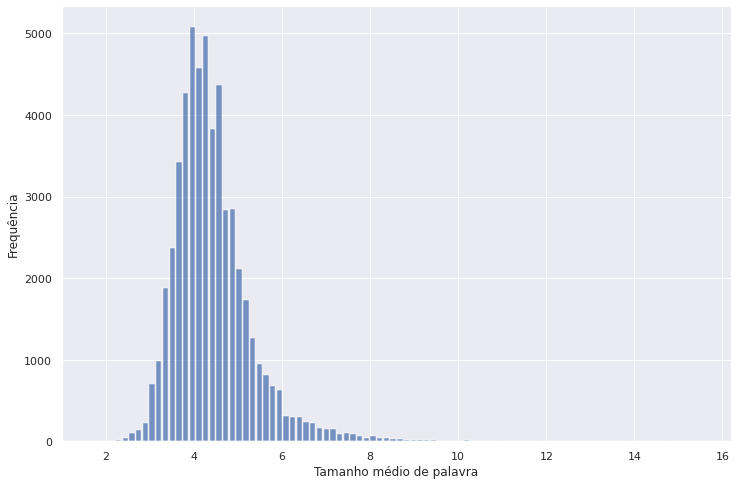

In [95]:
sns.set(rc={"figure.figsize": (12, 8)})

sns.histplot(data=formated_df, x="avg_word_length", bins=100, shrink=0.8)
plt.xlabel("Tamanho médio de palavra")
plt.ylabel("Frequência")
plt.xlim(formated_df["avg_word_length"].min(), formated_df["avg_word_length"].max())
plt.show()

## Separação dos dataframes em positivo e negativo e criação do corpus

In [96]:
df_positivo = formated_df.query("label == 'positivo'")
df_negativo = formated_df.query("label == 'negativo'")
df_all = formated_df

positive_text = " ".join(df_positivo.tweet)
negative_text = " ".join(df_negativo.tweet)
all_text = " ".join(df_all.tweet)

## Quantidade de tweets por período do dia.

#### Nota-se claramente que há uma maior quantidade de tweets de noite, provavelmente nos outros horários as pessoas estão ou trabalhando, estudando ou dormindo.

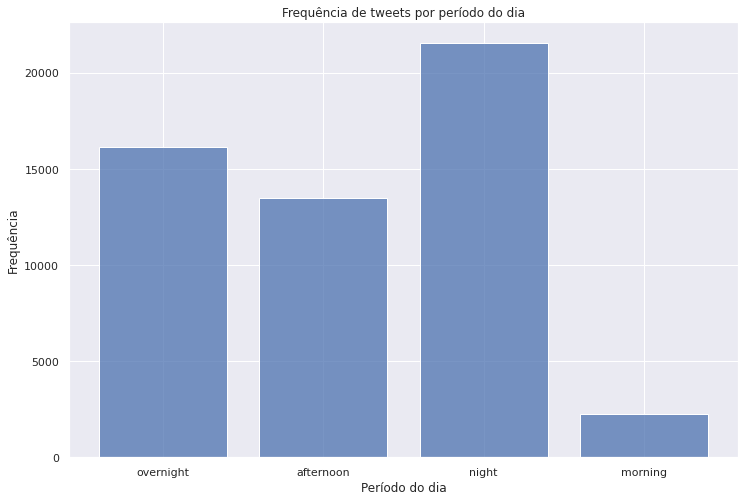

In [97]:
sns.histplot(data=formated_df, x="day_period", bins=5, shrink=0.8)
plt.xlabel("Período do dia")
plt.ylabel("Frequência")
plt.title("Frequência de tweets por período do dia")
plt.show()

<h2 style="">Durante a mineração dos dados foram obtidos mais tweets positivos do que negativos. ~50K de Positivos VS ~15K de negativos</h2>

## Quantidade de tweets por período do dia separado por sentimento.

#### Analogamente a quantidade a tendência é ter cerca de o dobro de tweets negativos do que positivos. Contudo, em períodos como noite e madrugada a proporção de tweets negativos é bem maior do que a esperada.

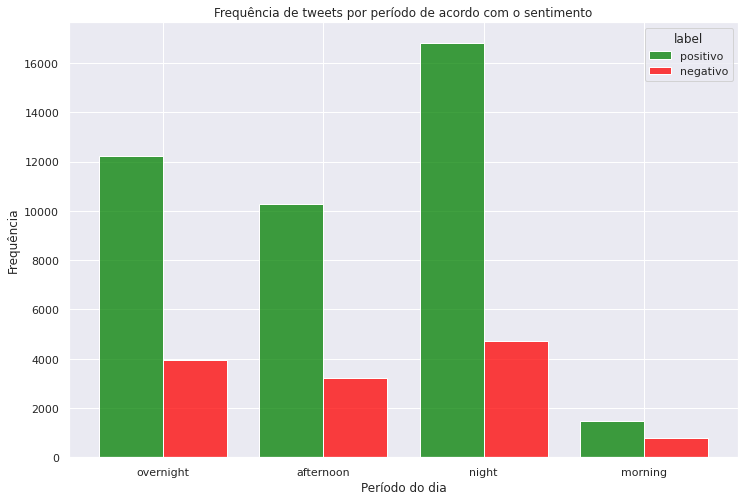

In [98]:
sns.histplot(
    data=formated_df,
    x="day_period",
    hue="label",
    bins=5,
    palette={"positivo": "green", "negativo": "red"},
    multiple="dodge",
    shrink=0.8,
)
plt.xlabel("Período do dia")
plt.ylabel("Frequência")
plt.title("Frequência de tweets por período de acordo com o sentimento")
plt.show()

## Cria os top 50 stop words que mais aparecem no corpus

analyzed stopwords:
 ['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivesse

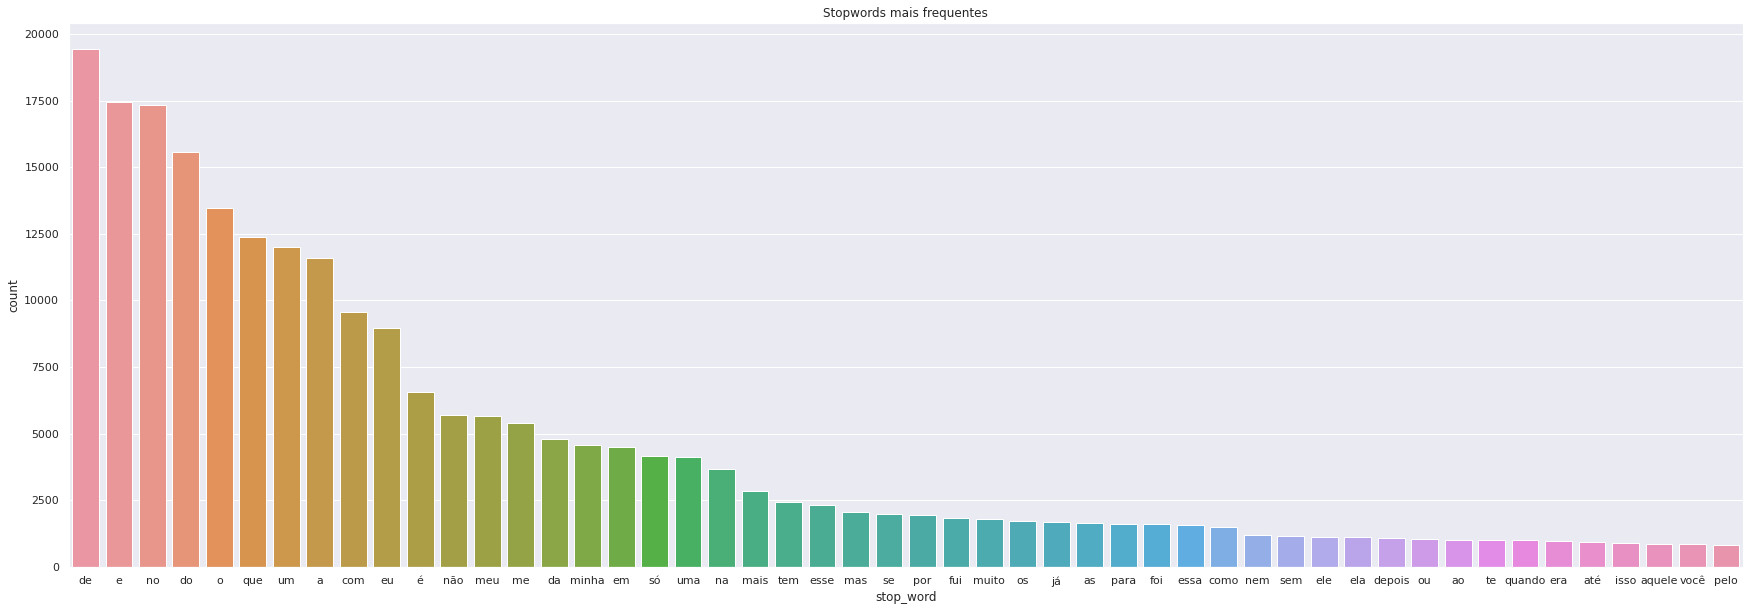

In [100]:
from collections import defaultdict

dic = defaultdict(int)

# stopwords = nltk.corpus.stopwords.words("portuguese")

print("analyzed stopwords:\n", stopwords)


for word in (all_text).split():
    if word in stopwords:
        dic[word] += 1


top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:50]  # top 50 stopwords


stopwords_df = pd.DataFrame(top, columns=["stop_word", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="stop_word", y="count", data=stopwords_df)
plt.title("Stopwords mais frequentes")
plt.show()

## O nltk considera como stop words algumas palavras que podem conter cunho sentimental, por conta disso essas palavras serão removidas desse vetor.

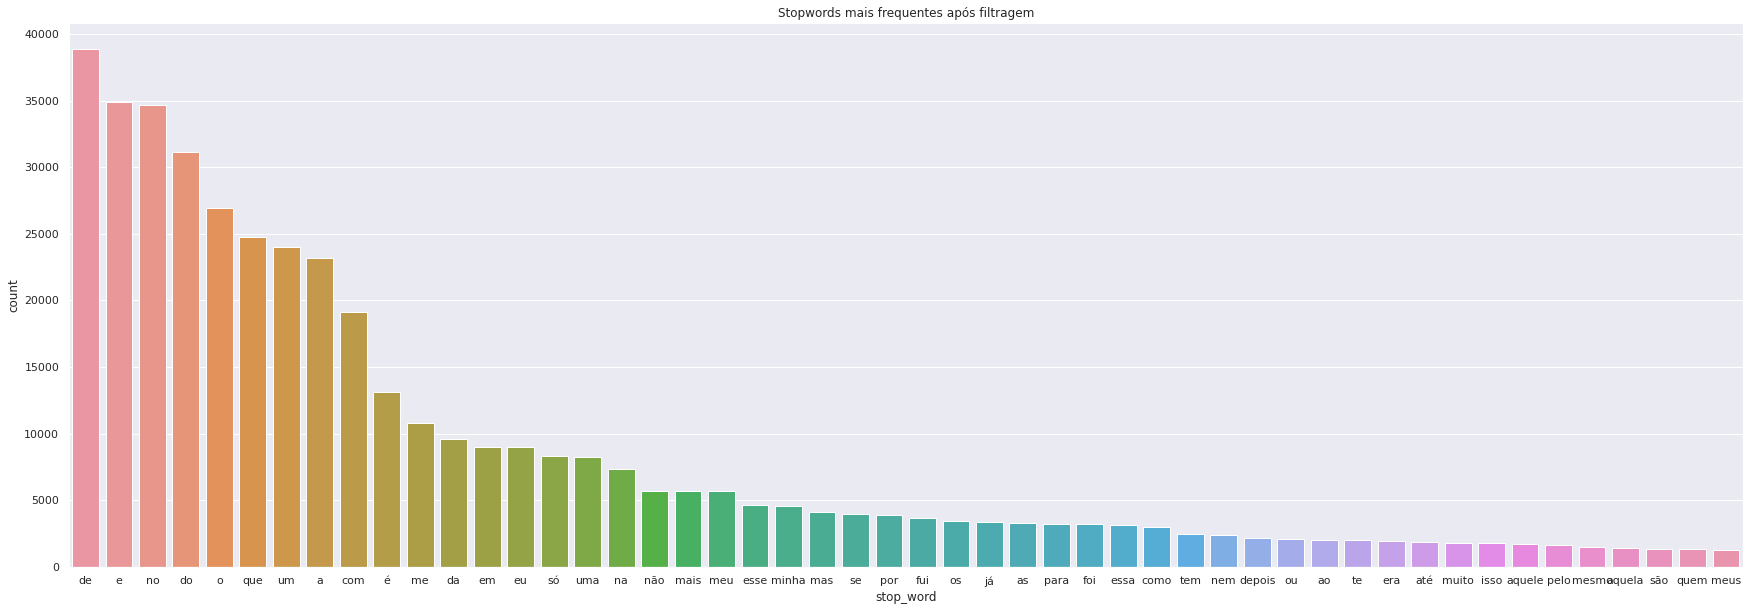

In [101]:
relevant_stop_words = [
    "eu",
    "não",
    "meu",
    "minha",
    "muito",
    "você",
    "tem",
    "ele",
    "ela",
    "quando",
    "sou",
    "você",
    "sem",
    "estou",
]  # stopwords consideradas relevantes para análise de sentimento, serão mantinidas em todo o processo de análise
stopwords = list(
    filter(lambda x: x not in relevant_stop_words, stopwords)
)  # remove do conjunto de stopwords palavras que não serão consideradas para filtragem

for word in all_text.split():
    if word in stopwords:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:50]  # top 50 stopwords


stopwords_df = pd.DataFrame(top, columns=["stop_word", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="stop_word", y="count", data=stopwords_df)
plt.title("Stopwords mais frequentes após filtragem")
plt.show()

## Análise das palavras mais frequentes que não são stop words.

#### Nota-se que há várias expressões e abreviações comuns  na internet e na língua portuguesa.

[('outback', 19449), ('de', 19439), ('e', 17466), ('no', 17328), ('do', 15575), ('o', 13464), ('que', 12373), ('um', 12010), ('a', 11598), ('subway', 11193), ('com', 9579), ('eu', 8959), ('pra', 7632), ('é', 6577), ('kfc', 6015), ('não', 5704), ('meu', 5659), ('me', 5418), ('comer', 5215), ('da', 4802), ('minha', 4583), ('em', 4504), ('vou', 4185), ('só', 4150), ('uma', 4120), ('madero', 3687), ('na', 3685), ('hoje', 3471), ('q', 3151), ('ir', 3020), ('mais', 2850), ('vai', 2565), ('vontade', 2558), ('tem', 2445), ('dia', 2412), ('esse', 2324), ('mc', 2153), ('mas', 2058), ('lanche', 2002), ('se', 1990), ('por', 1943), ('to', 1859), ('fui', 1828), ('mim', 1828), ('muito', 1812), ('melhor', 1755), ('agora', 1754), ('shopping', 1731), ('os', 1723), ('já', 1690), ('amo', 1681), ('as', 1659), ('p', 1654), ('aqui', 1630), ('para', 1614), ('queria', 1604), ('foi', 1603), ('essa', 1558), ('como', 1489), ('comi', 1468), ('donalds', 1441), ('steakhouse', 1419), ('hj', 1402), ('pro', 1370), ('tá

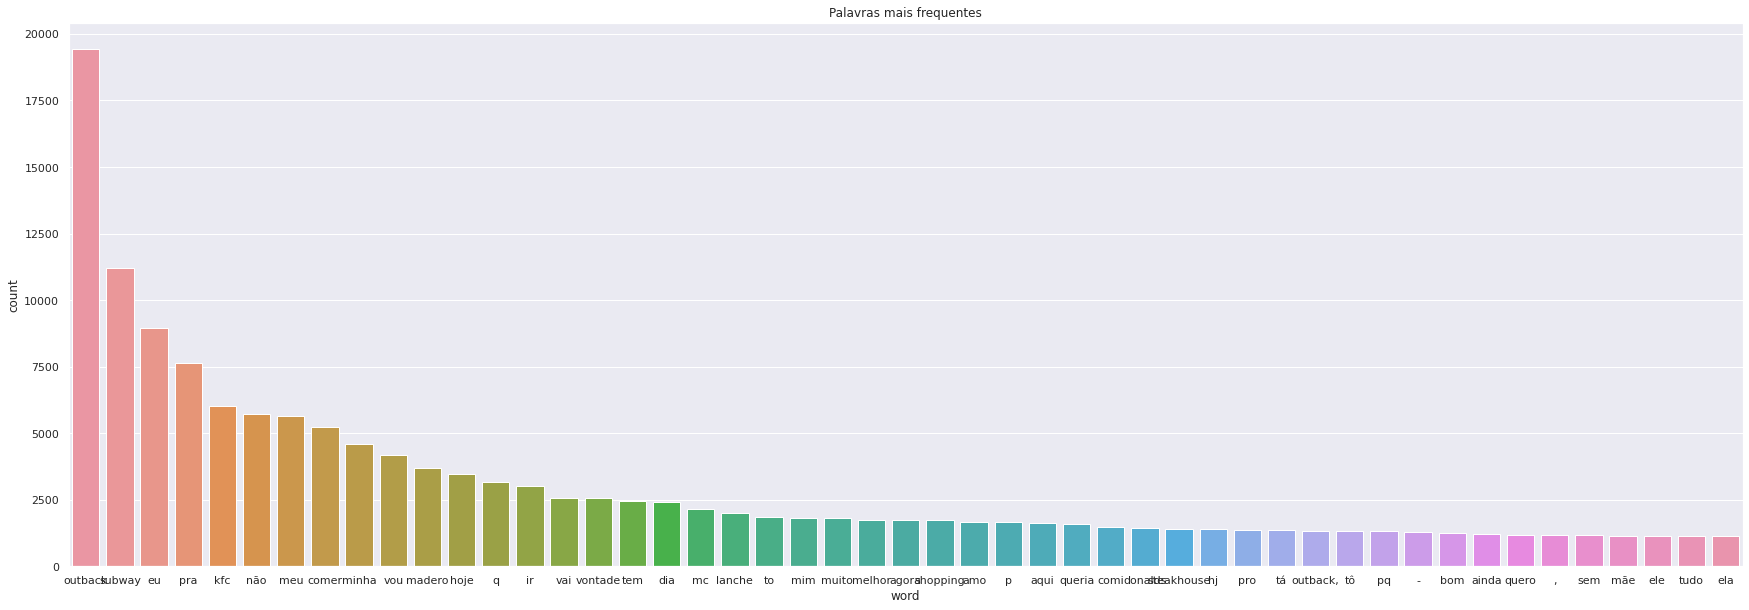

In [102]:
from collections import Counter


counter = Counter(all_text.split())
most = counter.most_common(80)
print(most)
print(len(most))

x, y = [], []
for word, count in most:
    if word not in stopwords:
        x.append(word)
        y.append(count)

most_common_words = list(zip(x, y))

most_common_words_df = pd.DataFrame(
    most_common_words, columns=["word", "count"]
)  # cria um dataframe com as palavras mais frequentes

sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="word", y="count", data=most_common_words_df)
plt.title("Palavras mais frequentes")
plt.show()

## Adiciona stopwords com palavras ou símbolos não relevantes para análise, descoberto com os gráficos anteriores.

In [103]:
invalid_terms = [
    ":p",  # indentificava apenas como "p"
    ":d",  # indentificava apenas como "d"
    "(",
    "pra",
    "q",
    "_",
    "((",
    "pq",
    "ai"
]  # palavras inrelevantes para análise de sentimento, ou termos abreviados já contidos em stopwords

stopwords.extend(invalid_terms)

counter = Counter(all_text.split())
most = counter.most_common(80)
print(most)
print(len(most))

x, y = [], []
for word, count in most:
    if word not in stopwords:
        x.append(word)
        y.append(count)


most_common_words_filtered = list(zip(x, y))

most_common_words_filtered_df = pd.DataFrame(
    most_common_words_filtered, columns=["word", "count"]
)

[('outback', 19449), ('de', 19439), ('e', 17466), ('no', 17328), ('do', 15575), ('o', 13464), ('que', 12373), ('um', 12010), ('a', 11598), ('subway', 11193), ('com', 9579), ('eu', 8959), ('pra', 7632), ('é', 6577), ('kfc', 6015), ('não', 5704), ('meu', 5659), ('me', 5418), ('comer', 5215), ('da', 4802), ('minha', 4583), ('em', 4504), ('vou', 4185), ('só', 4150), ('uma', 4120), ('madero', 3687), ('na', 3685), ('hoje', 3471), ('q', 3151), ('ir', 3020), ('mais', 2850), ('vai', 2565), ('vontade', 2558), ('tem', 2445), ('dia', 2412), ('esse', 2324), ('mc', 2153), ('mas', 2058), ('lanche', 2002), ('se', 1990), ('por', 1943), ('to', 1859), ('fui', 1828), ('mim', 1828), ('muito', 1812), ('melhor', 1755), ('agora', 1754), ('shopping', 1731), ('os', 1723), ('já', 1690), ('amo', 1681), ('as', 1659), ('p', 1654), ('aqui', 1630), ('para', 1614), ('queria', 1604), ('foi', 1603), ('essa', 1558), ('como', 1489), ('comi', 1468), ('donalds', 1441), ('steakhouse', 1419), ('hj', 1402), ('pro', 1370), ('tá

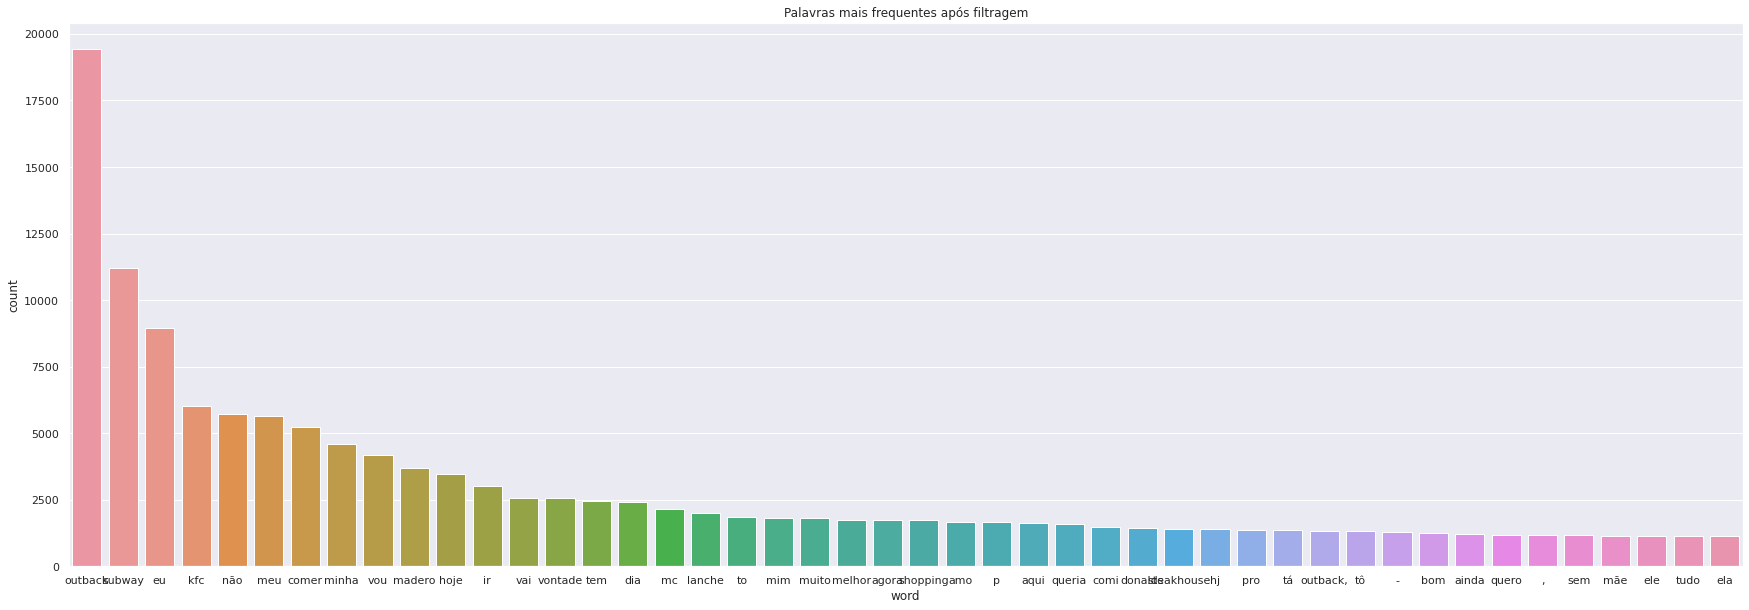

In [104]:
sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="word", y="count", data=most_common_words_filtered_df)
plt.title("Palavras mais frequentes após filtragem")
plt.show()

## Utilizando as análises anteriores é definido um conjunto final de stop words e utilizado para filtra todos os corpus

In [105]:
final_stop_words = stopwords


positive_filter = remover_stop_words(positive_text, final_stop_words)
negative_filter = remover_stop_words(negative_text, final_stop_words)
all_text_filter = remover_stop_words(all_text, final_stop_words)

## Plotagem visual das palavras mais comuns em cada um dos corpus.

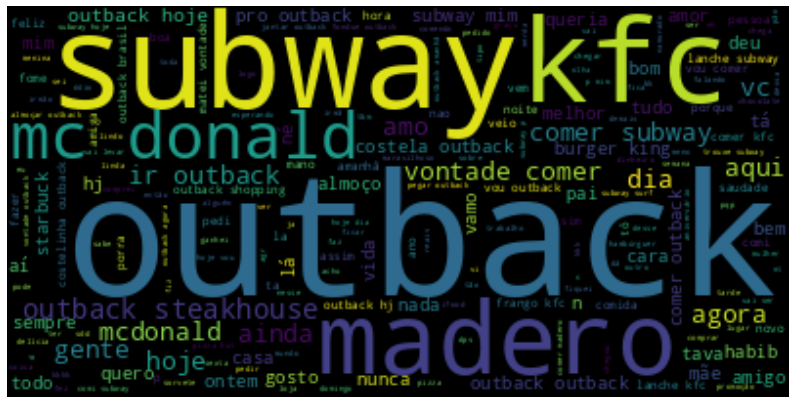

In [106]:
wordcloud = WordCloud().generate(all_text_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


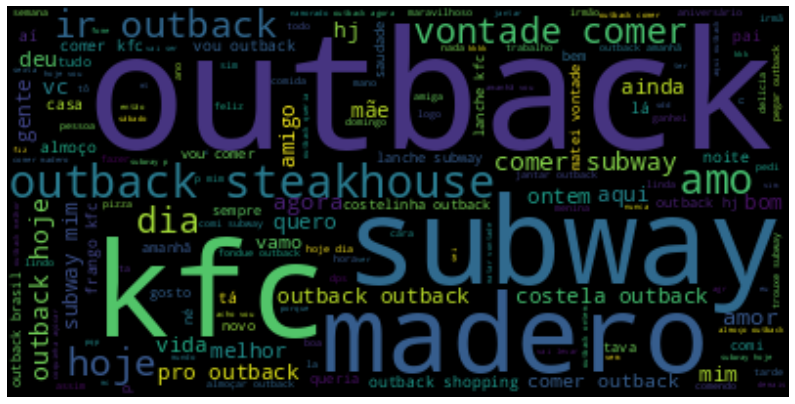

In [107]:
# Generate a word cloud image
wordcloud = WordCloud().generate(positive_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

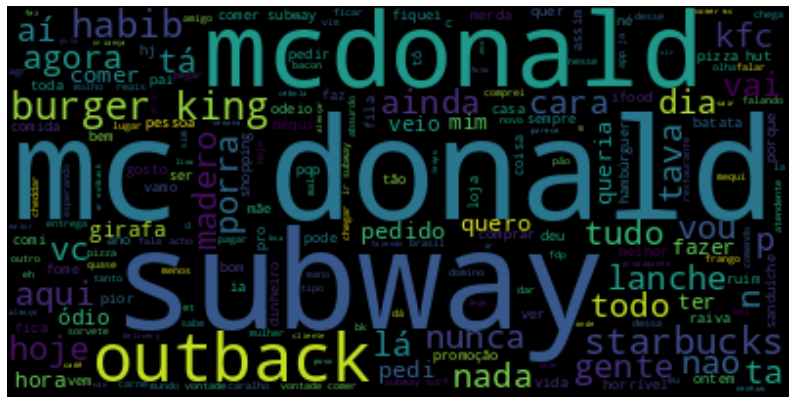

In [108]:
wordcloud = WordCloud().generate(negative_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Plotagem visual dos radicais mais comuns em cada um dos corpus.

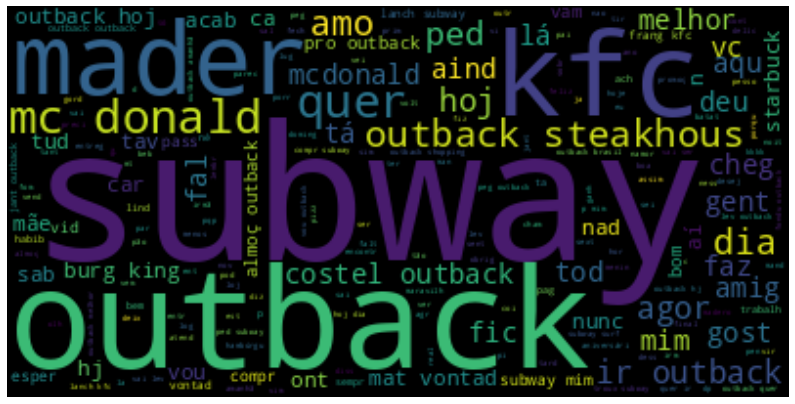

In [109]:
wordcloud = WordCloud().generate(stemming(all_text_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

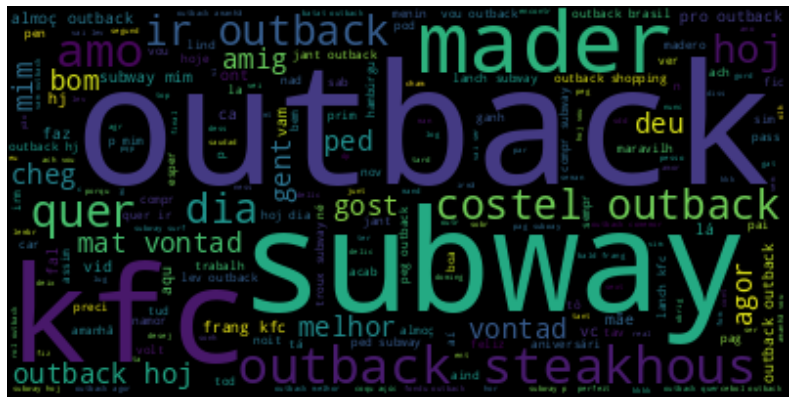

In [110]:
wordcloud = WordCloud().generate(stemming(positive_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

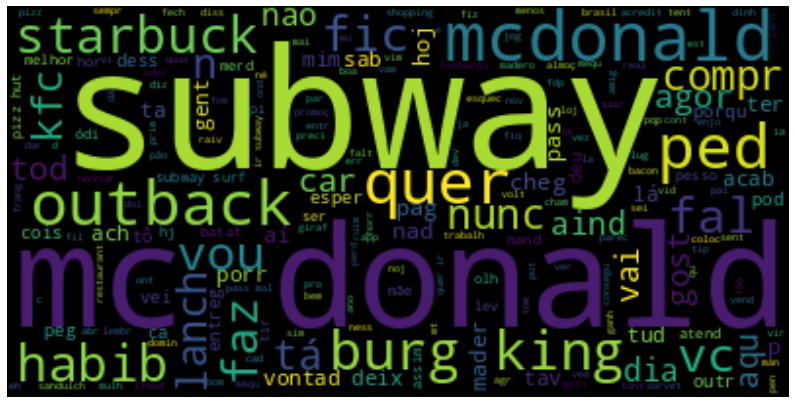

In [111]:
wordcloud = WordCloud().generate(stemming(negative_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Analise dos ngram mais comuns nos corpus.

## Há uma recorrencial de ngrams com termos como "gt", "it","amp" que não consegui identificar o que significam. Além disso há presença de muitas datas de notícias importante que aconteceram na época, e que as pessoas comentaram na época.

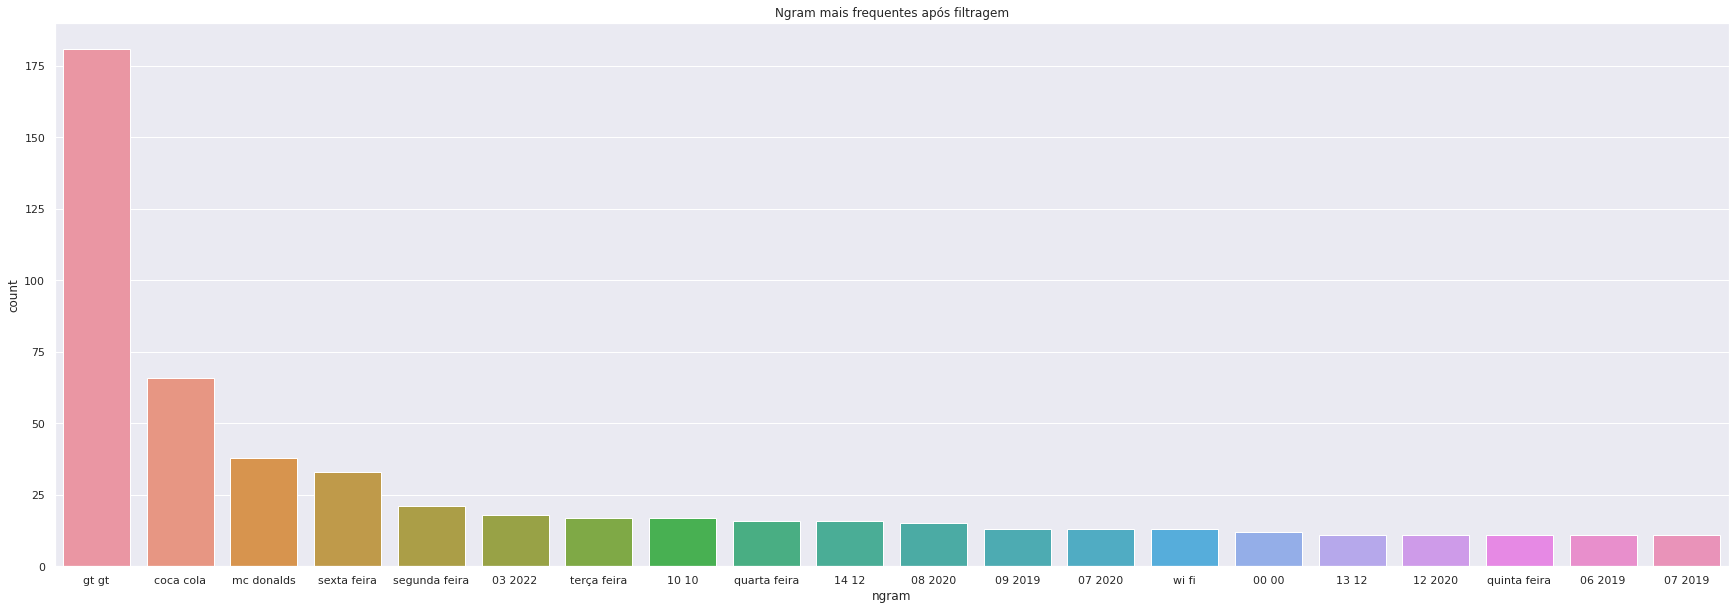

In [112]:
top_2_gram = get_top_ngram(all_text_filter.split(), gram_size=2, top_gram=20 )


top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])

sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="ngram", y="count", data=top_2_gram_df)
plt.title("Ngram mais frequentes após filtragem")
plt.show()

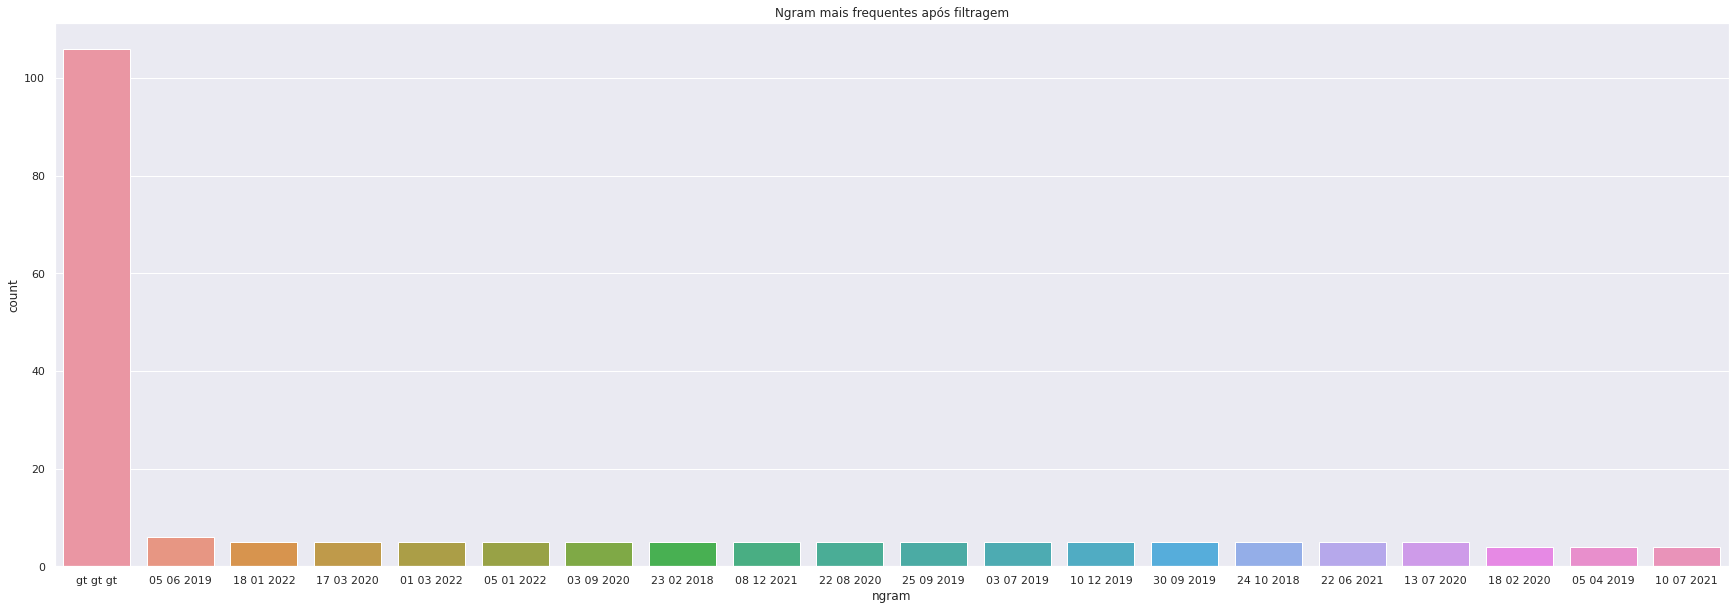

In [113]:
top_3_gram = get_top_ngram(all_text_filter.split(), gram_size=3, top_gram=20)


top_3_gram_df = pd.DataFrame(top_3_gram, columns=["ngram", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="ngram", y="count", data=top_3_gram_df)
plt.title("Ngram mais frequentes após filtragem")
plt.show()

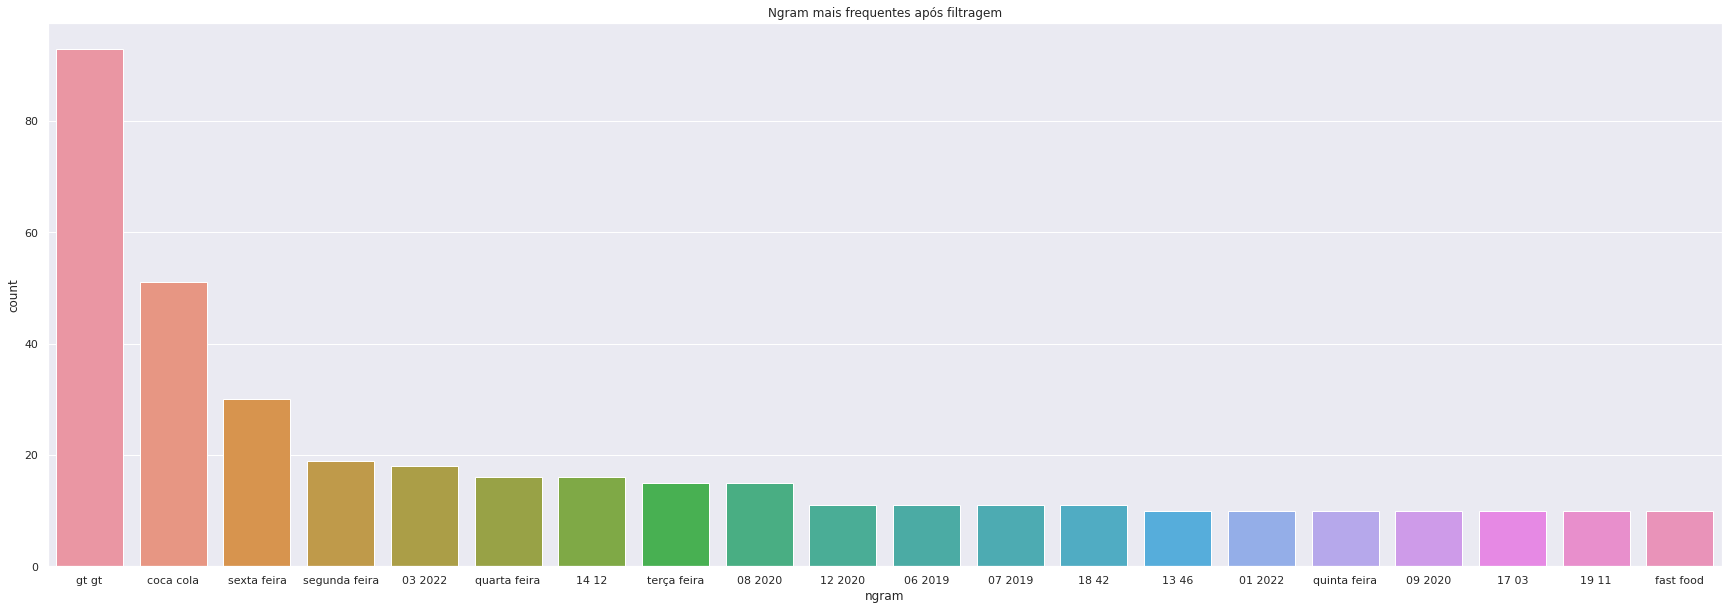

In [114]:
top_2_gram = get_top_ngram(positive_filter.split(), gram_size=2, top_gram=20 )

top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="ngram", y="count", data=top_2_gram_df)
plt.title("Ngram mais frequentes após filtragem")
plt.show()

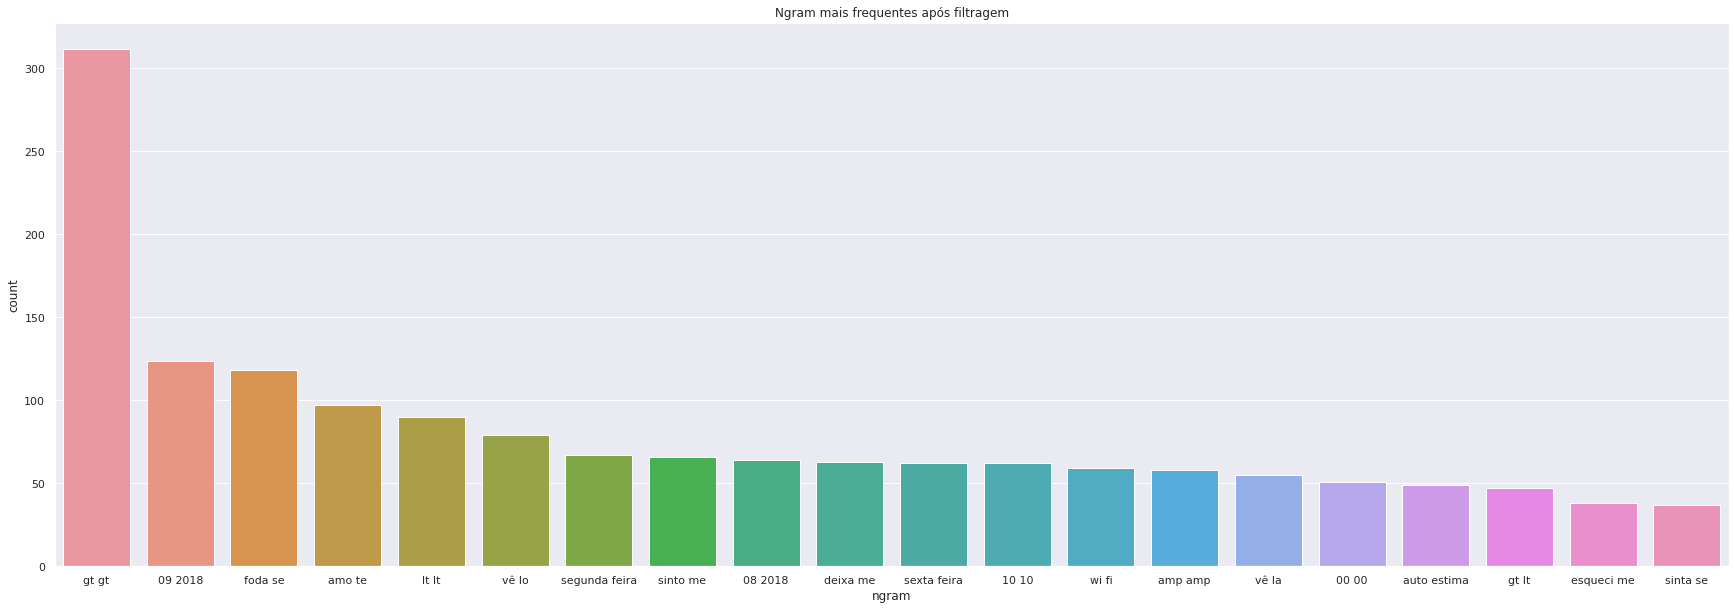

In [32]:
top_2_gram = get_top_ngram(negative_filter.split(), gram_size=2, top_gram=20 )

top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="ngram", y="count", data=top_2_gram_df)
plt.title("Ngram mais frequentes após filtragem")
plt.show()